In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import read_csv
from pandas import datetime

from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import itertools

from fbprophet import Prophet

In [122]:
#read dataset 'df_avocado'
df = pd.read_csv('df_avocado.csv', index_col = 0)

In [123]:
#Check dataset
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
11569,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
9593,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
10009,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
1819,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
9333,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


There are two types of avocado: conventional and organic, in this part, I will focus on conventional avocado's price in the total US.
Forecast conventional avocado's price from the 3 ways to compare the result: <br>
1. Prophet <br>
2. ARIMA<br>
3. EMA<br>

Let's start from Prophet.

### Prophet
##### Calculate prophet prediction

In [137]:
#Pick conventional avocado price in Total US
dp = df[df.type == "conventional"]
dp = dp[dp.region == "TotalUS"]
dp = dp[['Date','AveragePrice']]

dp.head()

,Date,AveragePrice
2703,2015-01-04,0.95
2702,2015-01-11,1.01
2701,2015-01-18,1.03
2700,2015-01-25,1.04
2699,2015-02-01,0.89


In [138]:
# Get counts of data before 2018 and after 2018
count_train = dp[dp.Date < '2018-01-01'].count()
count_test = dp[dp.Date > '2018-01-01'].count()
print(count_train, count_test)

Date            157
AveragePrice    157
dtype: int64 Date            12
AveragePrice    12
dtype: int64


In [155]:
dp = dp.rename(columns={'Date':'ds', 'AveragePrice':'y'})
dp.tail()

,ds,y
9094,2018-02-25,1.06
9093,2018-03-04,1.07
9092,2018-03-11,1.09
9091,2018-03-18,1.05
9090,2018-03-25,1.03


In [156]:
#spilt data before 2018 and after 2018 (157:12)
dp_train = dp[:157]
dp_test = dp[12:]
dp_test

,ds,y
2691,2015-03-29,1.04
2690,2015-04-05,1.06
2689,2015-04-12,1.02
2688,2015-04-19,1.03
2687,2015-04-26,1.07
...,...,...
9094,2018-02-25,1.06
9093,2018-03-04,1.07
9092,2018-03-11,1.09
9091,2018-03-18,1.05


In [157]:
#Prophet 
p = Prophet()
p.fit(dp_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [158]:
#prediction
future = p.make_future_dataframe(periods=730)
p_forecast = p.predict(future)
p_forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
882,2019-12-27,1.697080,1.395207,1.694954,1.603447,1.792927,-0.159245,-0.159245,-0.159245,-0.159245,-0.159245,-0.159245,0.0,0.0,0.0,1.537836
883,2019-12-28,1.697598,1.397824,1.683663,1.603771,1.793655,-0.156974,-0.156974,-0.156974,-0.156974,-0.156974,-0.156974,0.0,0.0,0.0,1.540623
884,2019-12-29,1.698115,1.400981,1.701613,1.604094,1.794382,-0.154248,-0.154248,-0.154248,-0.154248,-0.154248,-0.154248,0.0,0.0,0.0,1.543867
885,2019-12-30,1.698633,1.410202,1.708791,1.604465,1.795100,-0.151091,-0.151091,-0.151091,-0.151091,-0.151091,-0.151091,0.0,0.0,0.0,1.547542
886,2019-12-31,1.699151,1.407993,1.698123,1.604934,1.795818,-0.147533,-0.147533,-0.147533,-0.147533,-0.147533,-0.147533,0.0,0.0,0.0,1.551618


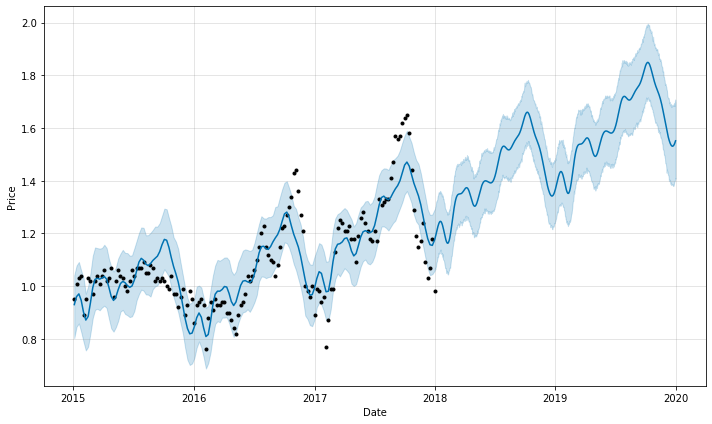

In [159]:
#Draw plot to show the forecasting result by prophet
figure = p.plot(p_forecast,xlabel='Date',ylabel='Price')

We had the price of avocade from 2015 to 2018, it shows as the black spots part in the graph. The future price after 2018-03 in the graph indicates the price will frequency oscillation go up.

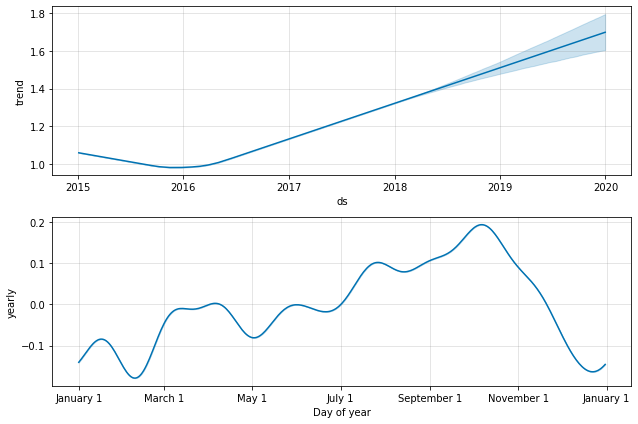

In [160]:
figure = p.plot_components(p_forecast)

Plotting the estimated components of the model shows the same result.

##### Valuation

Take orginal data of 2018 as a valuation as below:

In [161]:
dp_test['ds'] = [datetime.strptime(x, '%Y-%m-%d') for x in dp_test['ds']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


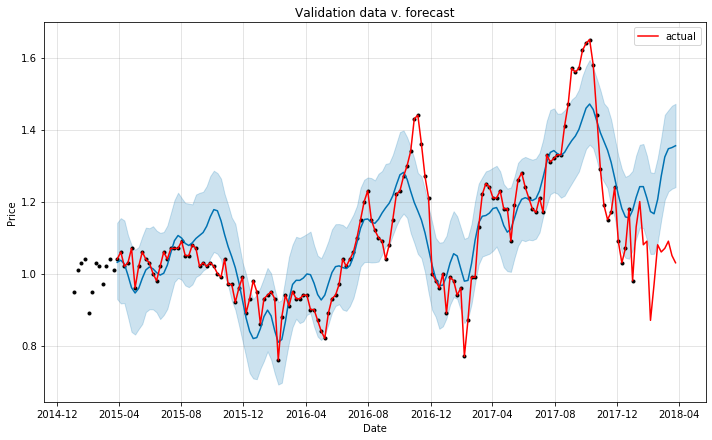

In [188]:
# Make prediction and acutal price plot to compare
pred_test = p.predict(dp_test)
    
# Plot the model, forecast, and actual (test) data
p.plot(pred_test, xlabel='Date',ylabel='Price')
plt.plot(dp_test['ds'], dp_test['y'], color='r', label='actual')
plt.title('Validation data v. forecast')
plt.legend();

The actual price and predication price in the same plot. Two price trend shapes are pretty similar but do not match very well. 
Prophet prediction is conservative than actual. The result of prophet prediction can be a reference.

### R² value valation

In [189]:
# R² score 
from sklearn.metrics import r2_score

r2_score(dp_test['y'], dp_train['y'])
0.9486081370449679

0.9486081370449679

Coefficient of determination R² close to 1, means the fit difference is really small, model fits very well.

### ARIMA

In [737]:
#load dataset as time series
da = df_before2018_pre
da_arima = da.set_index('Date')
da_arima

,AveragePrice
Date,
2015-01-04,0.95
2015-01-11,1.01
2015-01-18,1.03
2015-01-25,1.04
2015-02-01,0.89
...,...
2017-12-03,1.09
2017-12-10,1.03
2017-12-17,1.07


In [738]:
# #Time series object 'AveragePrice'
da_arima['AveragePrice'].astype(float)
da_arima.head()

,AveragePrice
Date,
2015-01-04,0.95
2015-01-11,1.01
2015-01-18,1.03
2015-01-25,1.04
2015-02-01,0.89


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 9 Text xticklabel objects>)

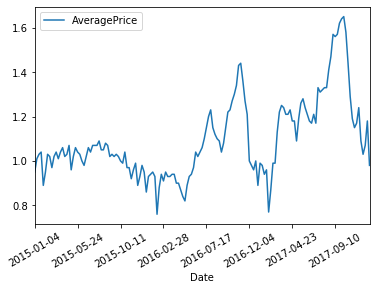

In [739]:
da_arima.plot()
plt.xticks(rotation =30)

In [740]:
da_arima.describe()

,AveragePrice
count,157.000000
mean,1.094459
std,0.179166
min,0.760000
25%,0.970000
50%,1.040000
75%,1.200000
max,1.650000


#### AIC to estimate the best model.

In [782]:
#find the best model by AIC from p,d,q 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

model = pm.auto_arima(da_arima, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(da), len(da)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-408.780, BIC=-396.581, Time=0.092 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-412.530, BIC=-406.430, Time=0.038 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-410.775, BIC=-401.626, Time=0.051 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-410.786, BIC=-401.637, Time=0.173 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-414.528, BIC=-411.479, Time=0.010 seconds
Total fit time: 0.381 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 208.264
Date:                Wed, 29 Jul 2020   AIC                           -414.528
Time:                        19:30:54   BIC                           -411.479
Sample:                             0   HQIC                          -

AIC:-214.528 is the lowest, ARIMA(0, 1, 0)x(0, 0, 0)  is the best model.

In [784]:
#ARIMA
arima_fit = SARIMAX(da_arima, order =(0,1,0), trend='c').fit() 
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                  157
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 208.265
Date:                Wed, 29 Jul 2020   AIC                           -412.530
Time:                        19:31:16   BIC                           -406.430
Sample:                    01-04-2015   HQIC                          -410.052
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.006      0.035      0.972      -0.011       0.011
sigma2         0.0041      0.000     10.422      0.000       0.003       0.005
===================================================================================
Ljung-Box (Q):                       29.27   Jarque-Bera (JB):                24.66
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               2.90   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [785]:
predict = arima_fit.predict(start = len(da_arima), end = len(da_arima)+63, dynamic = True)
predict_arima = pd.DataFrame({'Date':predict.index, 'AveragePrice':predict.values})
predict_arima

,Date,AveragePrice
0,2018-01-07,0.980192
1,2018-01-14,0.980385
2,2018-01-21,0.980577
3,2018-01-28,0.980769
4,2018-02-04,0.980962
...,...,...
59,2019-02-24,0.991538
60,2019-03-03,0.991731
61,2019-03-10,0.991923
62,2019-03-17,0.992115


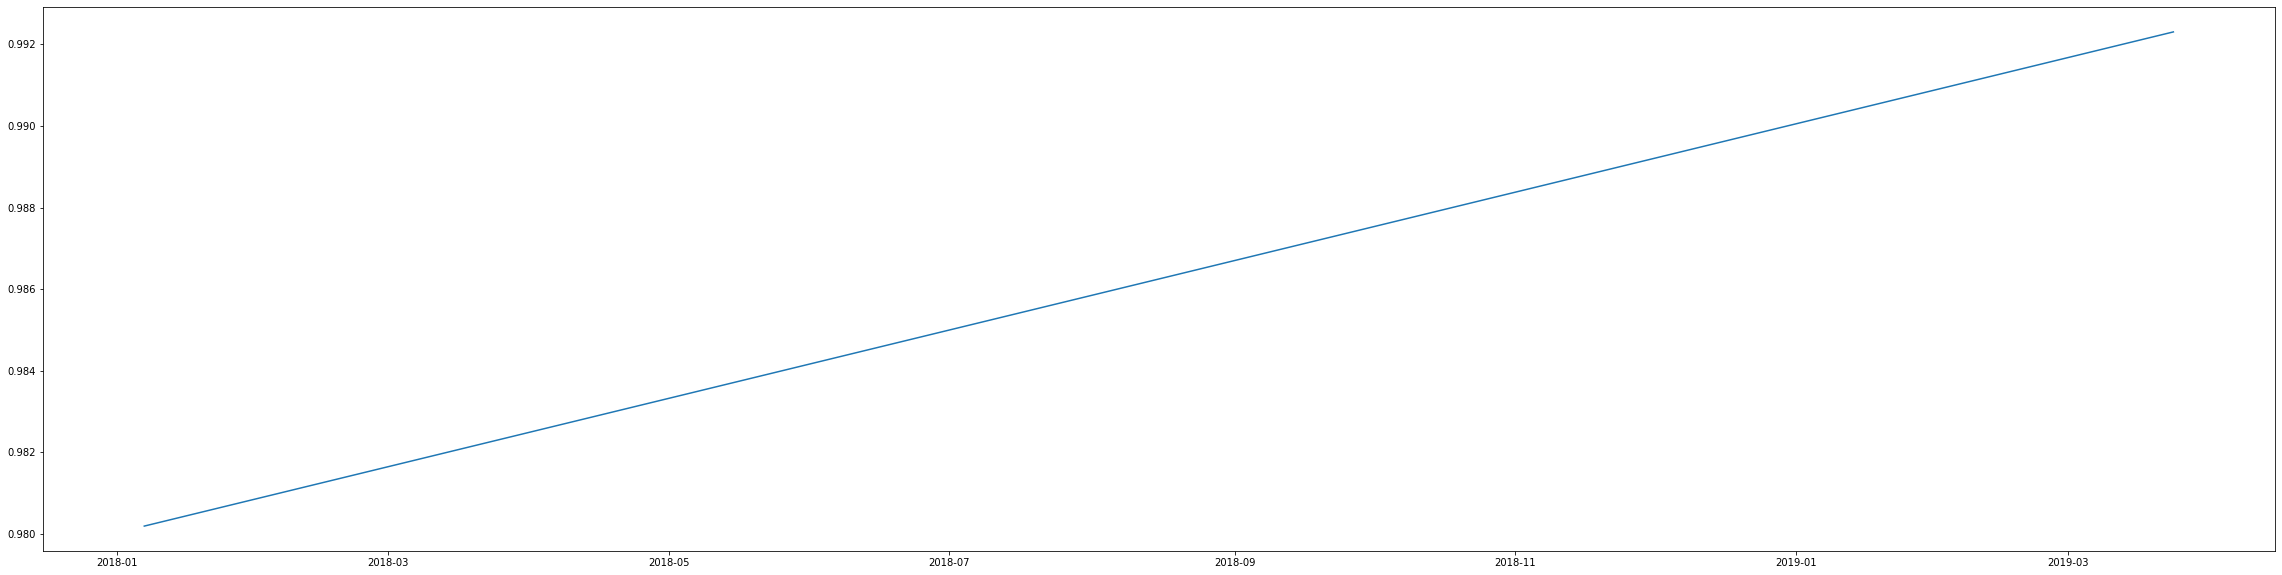

In [786]:
fig, ax = plt.subplots(figsize=(40, 10))
plt.plot(predict_arima['Date'], predict_arima['AveragePrice'])
plt.show()


ARIMA predicts the future price after 2018-03-25 before 2020-03-24, in the graph indicates the price will go up.

### EMA

In [678]:
ewm = pd.DataFrame.ewm(df_before2018_pre, span = 1)
ewm

EWM [com=0.0,min_periods=0,adjust=True,ignore_na=False,axis=0]

In [697]:
da_ema =pd.DataFrame(columns=['Date', 'AveragePrice'])
datelist = pd.date_range(pd.datetime(2018,1,1).strftime('%Y-%m-%d'), pd.datetime(2020,3,26).strftime('%Y-%m-%d'), freq='7D').tolist()
da_ema['Date'] = datelist 
da_ema.set_index = pd.to_datetime(da_ema['Date'])

da_ema['AveragePrice'] = pd.DataFrame.ewm(dt['AveragePrice'],span = len(da_ema['Date']), adjust=True).mean()

da_ema

,Date,AveragePrice
0,2018-01-01,1.459197
1,2018-01-08,1.287546
2,2018-01-15,1.321876
3,2018-01-22,1.265848
4,2018-01-29,1.336838
...,...,...
112,2020-02-24,1.344997
113,2020-03-02,1.352842
114,2020-03-09,1.372221
115,2020-03-16,1.375082


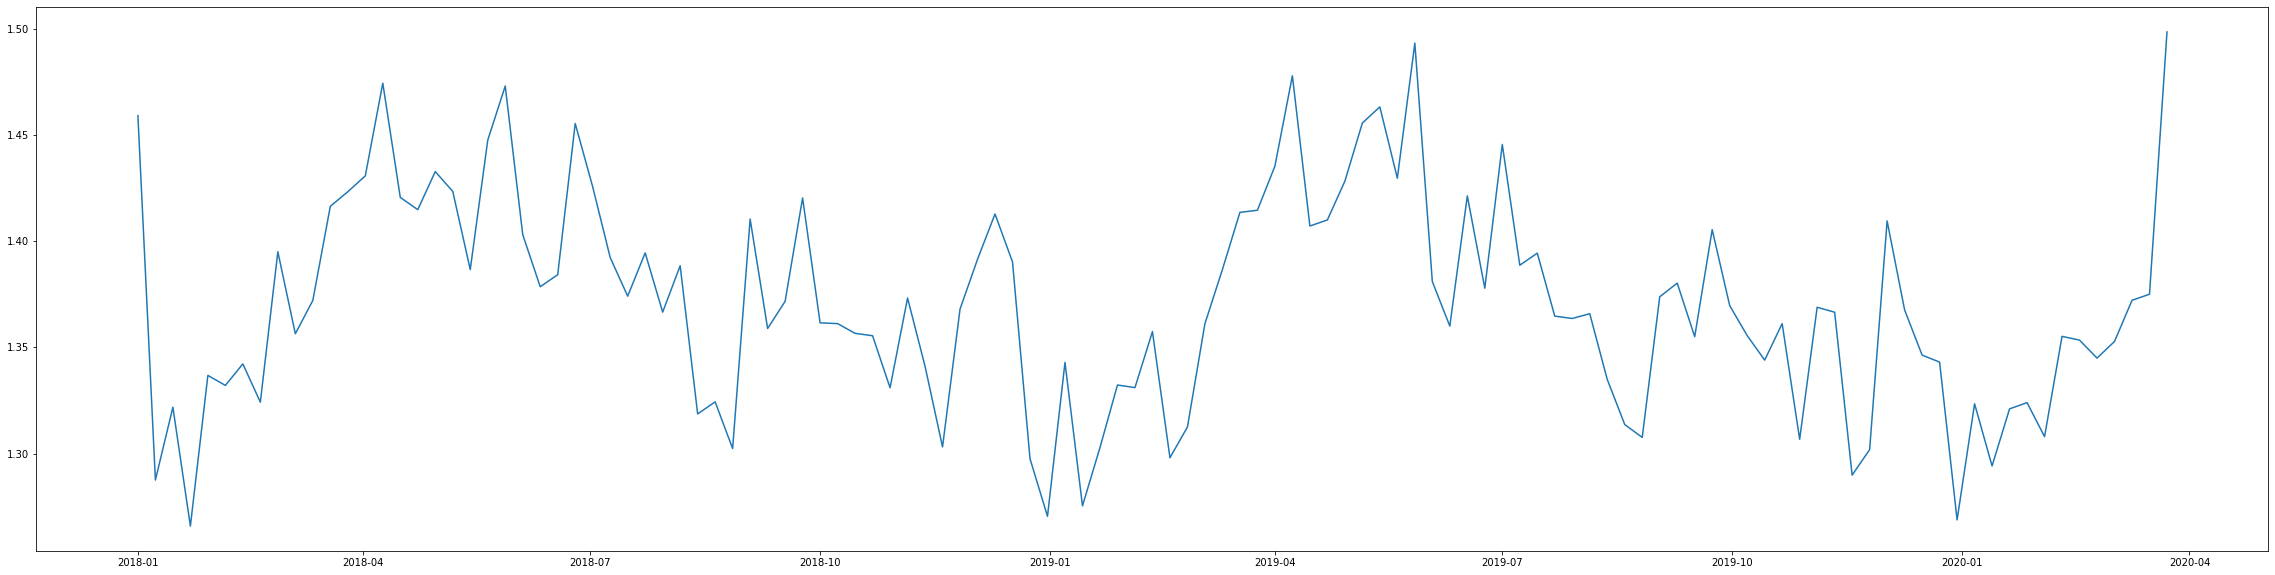

In [707]:
fig, ax = plt.subplots(figsize=(40, 10))
plt.plot(da_ema['Date'], da_ema.AveragePrice)
plt.show()

Exponential Moving Average shows the price in the future will be frequency oscillation,but cannot tell the trend is go up or go down.

#### Conclusion
Three of the predictions show the similar result. EMA responds quickly to any factor’s change, better than ARIMA in this project, Prophet  shows more details, clearest average price trend. In this project, the Prophet gives the best forecasting.<br>
Combining three models above, the average price of conventional avocados will be frequency oscillation go up  in the future. 
